In [4]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from numpy import linalg as LA
import math
from tqdm import tqdm
from sklearn.model_selection import KFold
import random
import time
import scipy.spatial.distance as dist

In [13]:
def polynomial_kernel(n):
    return lambda x, y: np.dot(np.transpose(x), y) ** n

def gaussian_kernel(gamma):
    return lambda x, y: np.exp(-gamma * np.linalg.norm(x - y) ** 2)

linear_kernel = polynomial_kernel(1)

The SMO algorithm gives an efficient way of solving the dual problem of the (regularized)
support vector machine optimization problem

https://cs229.stanford.edu/materials/smo.pdf

In [126]:

def split_x_y(row):
    return row[:-1], row[-1]

def predict(x, dataset, alphas, beta, sv_indecies, K):
    temp = [dataset[i][-1] * K(dataset[i][:-1], x) for i in sv_indecies]
    return beta + np.dot(np.array(alphas)[sv_indecies], temp)

# The Simplified Sequential Minimal Optimization Algorithm
def smo_svm(dataset: np.ndarray, kernel_function, C):
    num_objects, _ = dataset.shape
    alphas = np.zeros(num_objects)
    beta = 0
    eps = 10e-5
    iterations = 10
    iter = 0
    tolerance = 10e-5

    while iter < iterations:
        updated = False
        for i in range(num_objects):
            x_i, y_i = split_x_y(dataset[i])
            E_i = predict(x_i, dataset, alphas, beta, range(num_objects), kernel_function) - y_i
            # kkt conditions
            if (y_i * E_i < -tolerance and alphas[i] < C) or (y_i * E_i > tolerance and alphas[i] > 0):
                j = i
                while j == i:
                    j = random.randint(0, num_objects - 1)
            
                x_j, y_j = split_x_y(dataset[j])
                E_j = predict(x_j, dataset, alphas, beta, range(num_objects), kernel_function) - y_j
                alpha_i_old = alphas[i]
                alpha_j_old = alphas[j]

                # alpha j borders: 0 <= alpha j <= c
                if y_i == y_j:
                    l, h = max(0, alphas[i] + alphas[j] - C), min(C, alphas[i] + alphas[j])
                else:
                    l, h = max(0, alphas[j] - alphas[i]), min(C, C + alphas[j] - alphas[i])
                if l == h:
                    continue
                
                # η to find alpha j to maximize the objective function
                eta = 2 * kernel_function(x_i, x_j) - kernel_function(x_i, x_i) - kernel_function(x_j, x_j)

                # For our purposes, if η = 0, you can treat this as a case where we cannot make progress on this pair of α’s.
                if eta >= 0:
                    continue
                
                # update alpha j
                alphas[j] = np.clip(alphas[j] - y_j * (E_i - E_j) / eta, l, h)

                # update i
                if abs(alphas[j] - alpha_j_old) < eps:
                    continue
                alphas[i] += y_i * y_j * (alpha_j_old - alphas[j])

                # the threshold b such that the KKT conditions are satisfied for the ith and jth examples

                # ai in the bounds
                condition_i = 0 < alphas[i] < C

                # xi -> yi
                beta_1 = beta - E_i - y_i * (alphas[i] - alpha_i_old) * kernel_function(x_i, x_i) - y_j * (
                        alphas[j] - alpha_j_old) * kernel_function(x_i, x_j)


                # aj in the bounds
                condition_j = 0 < alphas[j] < C

                # xj -> yj
                beta_2 = beta - E_j - y_i * (alphas[i] - alpha_i_old) * kernel_function(x_i, x_j) - y_j * (
                        alphas[j] - alpha_j_old) * kernel_function(x_j, x_j)

                # if condition_i and condition_j can use any

                if condition_i:
                    beta = beta_1
                elif condition_j:
                    beta = beta_2
                else:
                    beta = (beta_1 + beta_2) / 2
                    
                updated = True
        if not updated:
            iter += 1
    sv_indecies = np.where(np.array(alphas) > 0)[0]

    return alphas, beta, sv_indecies


def calc_accuracy(train_dataset, test_dataset, alphas, beta, sv_indecies, kernel_function):
    correct = 0
    for i in range(len(test_dataset)):
        x_i, target = split_x_y(test_dataset[i])
        predicted = np.sign(predict(x_i, train_dataset, alphas, beta, sv_indecies, kernel_function))
        correct += (predicted == target)
    return correct / len(test_dataset)

def draw_plot(title, dataset, alphas, beta, sv_indecies, kernel_function):
    plt.title(title)
    details = 40
    xs = []
    attrs = len(dataset[0][:-1])
    for i in range(attrs):
        minn = np.min(dataset[:, i])
        maxx = np.max(dataset[:, i])
        xs.append(np.arange(minn, maxx + (maxx - minn) / details, (maxx - minn) / details))
    points = np.array(np.meshgrid(*xs)).T.reshape(-1, attrs)
    for point in points:
        z = predict(point, dataset, alphas, beta, sv_indecies, kernel_function)
        c = '#9c6853'
        c = '#517354' if z <= 0 else c
        c = '#c18653' if z > 1 else c
        c = '#38624c' if z < -1 else c
        plt.scatter(*point, color=c, s=50, marker='s')

    for i in range(len(dataset)):
        features, label = split_x_y(dataset[i])
        c = '#2e438a' if label == -1 else '#8f281f'
        if i in sv_indecies:
            plt.scatter(*features, color=c, s=50, edgecolors='white')
        else:
            plt.scatter(*features, color=c, s=50, edgecolors='black')
    plt.show()



In [127]:
f = open('chips.csv', 'r')
labels = {'P': 1, 'N': -1}
f.readline()
content = f.read().split()
num_objects = len(content)
dataset = list()
for i in range(num_objects):
    line = content[i].split(',')
    dataset.append(list(map(float, line[:-1])) + [labels[line[-1]]])
dataset = np.array(dataset)

In [128]:
cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
ns = [2, 3, 4, 5]
gs = [1, 2, 3, 4, 5]


def fit(dataset):
    best_gauss = [0, 0, 0]
    best_poly =  [0, 0, 0]
    best_linear = [0, 0]

    for c in tqdm(cs):
        accuracies = []
        for train_index, test_index in KFold(n_splits=3, shuffle=True).split(dataset):
            train_dataset = dataset[train_index]
            test_dataset = dataset[test_index]
            alphas, beta, sv_indecies = smo_svm(train_dataset, linear_kernel, c)
            accuracy = calc_accuracy(train_dataset, test_dataset, alphas, beta, sv_indecies, linear_kernel)
            accuracies.append(accuracy)
        avg = np.mean(accuracies)
        if avg > best_linear[0]:
            best_linear = [avg, c]
        
        for n in ns:
            accuracies = []
            for train_index, test_index in KFold(n_splits=3, shuffle=True).split(dataset):
                train_dataset = dataset[train_index]
                test_dataset = dataset[test_index]
                alphas, beta, sv_indecies = smo_svm(train_dataset, polynomial_kernel(n), c)
                accuracy = calc_accuracy(train_dataset, test_dataset, alphas, beta, sv_indecies, polynomial_kernel(n))
                accuracies.append(accuracy)
            avg = np.mean(accuracies)
            if avg > best_poly[0]:
                best_poly = [avg, c, n]
        for g in gs:
            accuracies = []
            for train_index, test_index in KFold(n_splits=3, shuffle=True).split(dataset):
                train_dataset = dataset[train_index]
                test_dataset = dataset[test_index]
                alphas, beta, sv_indecies = smo_svm(train_dataset, gaussian_kernel(g), c)
                accuracy = calc_accuracy(train_dataset, test_dataset, alphas, beta, sv_indecies, gaussian_kernel(g))
                accuracies.append(accuracy)
            avg = np.mean(accuracies)
            if avg > best_gauss[0]:
                best_gauss = [avg, c, g]
        
    print('linear: ', best_linear)
    print('gaussian: ', best_gauss)
    print('polynomial: ', best_poly)
    return best_linear, best_gauss, best_poly

def plots(dataset, best_linear, best_gauss, best_poly):
    alphas, beta, sv_indecies = smo_svm(dataset, linear_kernel, best_linear[1])
    draw_plot('linear', dataset, alphas, beta, sv_indecies, linear_kernel)

    alphas, beta, sv_indecies = smo_svm(dataset, gaussian_kernel(best_gauss[2]), C=best_gauss[1])
    draw_plot('gaussian', dataset, alphas, beta, sv_indecies, gaussian_kernel(best_gauss[2]))

    alphas, beta, sv_indecies = smo_svm(dataset, polynomial_kernel(best_poly[2]), C=best_poly[1])
    draw_plot('polynomial', dataset, alphas, beta, sv_indecies, polynomial_kernel(best_poly[2]))

In [129]:
best_linear, best_gauss, best_poly = fit(dataset)


100%|██████████| 8/8 [02:52<00:00, 21.61s/it]

linear:  [0.5254273504273504, 100.0]
gaussian:  [0.7967948717948717, 5.0, 2]
polynomial:  [0.7461538461538462, 1.0, 4]


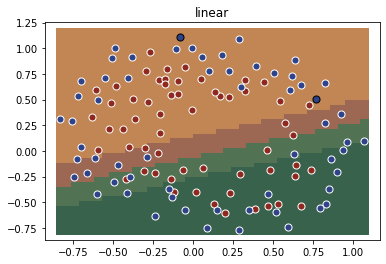

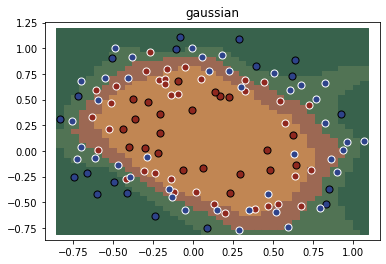

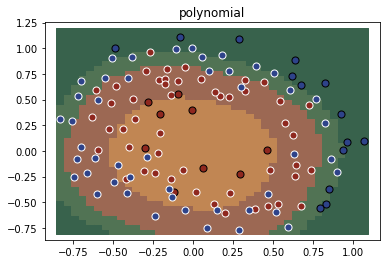

In [130]:
plots(dataset, best_linear, best_gauss, best_poly)

In [131]:
f = open('geyser.csv', 'r')
labels = {'P': 1, 'N': -1}
f.readline()
content = f.read().split()
num_objects = len(content)
dataset = list()
for i in range(num_objects):
    line = content[i].split(',')
    dataset.append(list(map(float, line[:-1])) + [labels[line[-1]]])
dataset = np.array(dataset)

In [132]:
best_linear, best_gauss, best_poly = fit(dataset)

100%|██████████| 8/8 [11:19<00:00, 84.99s/it]

linear:  [0.9009009009009009, 0.05]
gaussian:  [0.9054054054054054, 0.5, 1]
polynomial:  [0.7072072072072073, 0.05, 2]


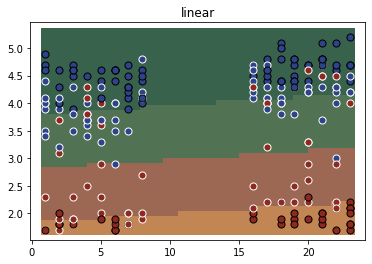

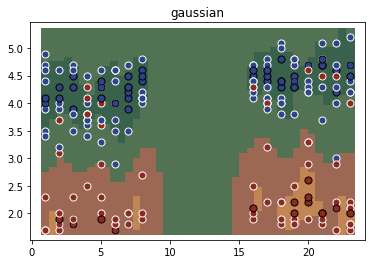

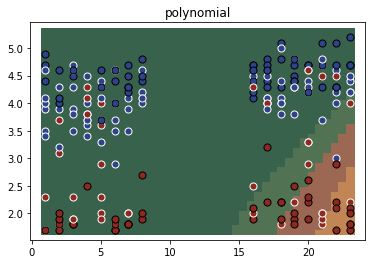

In [135]:
plots(dataset, best_linear, best_gauss, best_poly)